In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Imports excel spreadsheet file
df = pd.read_excel('../Datasets/Online Retail.xlsx', sheet_name='Online Retail')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Data Cleanup

In [3]:
# Drop cancelled orders 

df = df.loc[df['Quantity'] > 0]

In [4]:
# Drop records with no customer ID

df = df[pd.notnull(df['CustomerID'])]

In [5]:
# Exclude incomplete month

df = df.loc[df['InvoiceDate'] < '2011-12-01']

In [6]:
# Compute total sales from the Quantity and Unit price columns

df['Sales'] = df['Quantity'] * df['UnitPrice']

In [7]:
# Per-customer data - purchase history of individual customers

customer_df = df.groupby('CustomerID').agg({
    'Sales': sum,
    'InvoiceNo': lambda x: x.nunique()
})

In [8]:
customer_df.columns = ['TotalSales', 'OrderCount']
customer_df['AvgOrderValue'] = customer_df['TotalSales']/customer_df['OrderCount']

In [9]:
customer_df

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,77183.60,1,77183.600000
12347.0,4085.18,6,680.863333
12348.0,1797.24,4,449.310000
12349.0,1757.55,1,1757.550000
12350.0,334.40,1,334.400000
...,...,...,...
18280.0,180.60,1,180.600000
18281.0,80.82,1,80.820000
18282.0,100.21,1,100.210000


In [10]:
# Normalise the scales of each column for clustering by ranking the data

# Ranks the data
rank_df  = customer_df.rank(method='first')

In [11]:
rank_df

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,4290.0,1.0,4298.0
12347.0,3958.0,3470.0,3888.0
12348.0,3350.0,2861.0,3303.0
12349.0,3321.0,2.0,4238.0
12350.0,1241.0,3.0,2561.0
...,...,...,...
18280.0,571.0,1537.0,1094.0
18281.0,104.0,1538.0,169.0
18282.0,158.0,1539.0,266.0


In [12]:
# Normalises the data to have a mean of 0 and STDV of 1

normalized_df = (rank_df - rank_df.mean()/ rank_df.std())

In [13]:
normalized_df

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,4288.267748,-0.732252,4296.267748
12347.0,3956.267748,3468.267748,3886.267748
12348.0,3348.267748,2859.267748,3301.267748
12349.0,3319.267748,0.267748,4236.267748
12350.0,1239.267748,1.267748,2559.267748
...,...,...,...
18280.0,569.267748,1535.267748,1092.267748
18281.0,102.267748,1536.267748,167.267748
18282.0,156.267748,1537.267748,264.267748


## k-meas clustering

In [33]:
# k-means package

from sklearn.cluster import KMeans

In [34]:
# fit k-means model

kmeans = KMeans(n_clusters=4).fit(normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']])

In [35]:
# labels

kmeans.labels_

array([1, 2, 2, ..., 3, 0, 2])

In [36]:
# clusters

kmeans.cluster_centers_

array([[2419.400732  , 3036.05413514, 1350.93057493],
       [1978.48337859, 1090.16887765, 3134.24703208],
       [3643.3294761 , 3390.96880591, 3228.65751843],
       [ 599.73243821, 1158.28780002,  829.2058471 ]])

In [37]:
# Create dataframe for visualisation

four_cluster_df = normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']].copy(deep=True)
four_cluster_df['Cluster'] = kmeans.labels_

In [38]:
four_cluster_df

,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12346.0,4288.267748,-0.732252,4296.267748,1
12347.0,3956.267748,3468.267748,3886.267748,2
12348.0,3348.267748,2859.267748,3301.267748,2
12349.0,3319.267748,0.267748,4236.267748,1
12350.0,1239.267748,1.267748,2559.267748,1
...,...,...,...,...
18280.0,569.267748,1535.267748,1092.267748,3
18281.0,102.267748,1536.267748,167.267748,3
18282.0,156.267748,1537.267748,264.267748,3


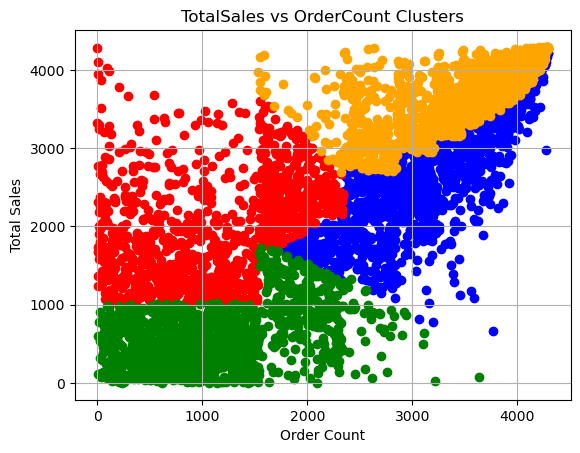

In [39]:
# Visualise the clusters

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['TotalSales'],
    c='blue'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['TotalSales'],
    c='red'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['TotalSales'],
    c='orange'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['TotalSales'],
    c='green'
)

plt.title('TotalSales vs OrderCount Clusters')
plt.xlabel('Order Count')
plt.ylabel('Total Sales')

plt.grid()
plt.show()

## Selecting the best number of segments

In [40]:
# silhouette coefficient package to select number of clusters

from sklearn.metrics import silhouette_score

In [41]:
# Calculate the silhouette score 

for n_clusters in [4,5,6,7,8]:
    kmeans = KMeans(n_clusters=4).fit(normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']])
    silhouette_avg = silhouette_score(normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']], kmeans.labels_)
    print('Silhouette Score %i Clusters: %0.4f' % (n_clusters, silhouette_avg))

Silhouette Score 4 Clusters: 0.4117
Silhouette Score 5 Clusters: 0.4112
Silhouette Score 6 Clusters: 0.4114
Silhouette Score 7 Clusters: 0.4111
Silhouette Score 8 Clusters: 0.4114


## Interpreting Customer Segments

In [42]:
# Kmeans clustering model with best no. of clusters

kmeans = KMeans(n_clusters=4).fit(normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']])

In [43]:
# Store in dataframe

four_cluster_df = normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']].copy(deep=True)
four_cluster_df['Cluster'] = kmeans.labels_

In [44]:
four_cluster_df

,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12346.0,4288.267748,-0.732252,4296.267748,3
12347.0,3956.267748,3468.267748,3886.267748,1
12348.0,3348.267748,2859.267748,3301.267748,1
12349.0,3319.267748,0.267748,4236.267748,3
12350.0,1239.267748,1.267748,2559.267748,3
...,...,...,...,...
18280.0,569.267748,1535.267748,1092.267748,0
18281.0,102.267748,1536.267748,167.267748,0
18282.0,156.267748,1537.267748,264.267748,0


In [32]:
# Look at the centers of each cluster

kmeans.cluster_centers_

array([[ 620.15957054, 1179.74986015,  839.43810546],
       [3643.01286316, 3386.75176192, 3239.19403545],
       [2458.86860608, 3075.19264041, 1352.48770479],
       [1978.74335747, 1094.29401413, 3131.10170643]])

In [46]:
# choose cluster

high_value_cluster = four_cluster_df.loc[four_cluster_df['Cluster'] == 2]
high_value_cluster.head()

,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12364.0,2676.267748,2346.267748,2558.267748,2
12399.0,2809.267748,2865.267748,2018.267748,2
12413.0,2347.267748,2350.267748,1845.267748,2
12414.0,1923.267748,2351.267748,1159.267748,2
12421.0,2426.267748,2866.267748,1326.267748,2


In [48]:
# Find out the best selling item for each cluster

high_value_customer = four_cluster_df.loc[four_cluster_df['Cluster'] == 2]

pd.DataFrame(
    df.loc[
        df['CustomerID'].isin(high_value_cluster.index)
    ].groupby('Description').count())[
    'StockCode'].sort_values(ascending=False).head()

Description
WHITE HANGING HEART T-LIGHT HOLDER    617
REX CASH+CARRY JUMBO SHOPPER          437
REGENCY CAKESTAND 3 TIER              316
ASSORTED COLOUR BIRD ORNAMENT         316
PARTY BUNTING                         314
Name: StockCode, dtype: int64